# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import math
import tensorflow as tf
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from trading_environment import (Trading_Environment,
                                 read_data,
                                 StandardScaler,
                                 format_price
                                )

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
tf.keras.utils.set_random_seed(42)

In [2]:
# Download Sample Data
csv_file = "data/ftse100.csv"
start_date = "2021-01-01"
end_date = "2024-01-01"

data = read_data(csv_file, start_date, end_date)
# ticker = '^FTSE'
# data = yf.download([ticker], start=start_date, end=end_date)
data.head()

,adj_close,close,high,low,open,volume
date,,,,,,
2021-01-04,6571.899902,6571.899902,6662.700195,6460.500000,6460.500000,965097800
2021-01-05,6612.299805,6612.299805,6622.799805,6544.299805,6571.899902,718950800
2021-01-06,6841.899902,6841.899902,6859.100098,6611.899902,6612.299805,1249709500
2021-01-07,6857.000000,6857.000000,6903.600098,6795.100098,6841.899902,939652600
2021-01-08,6873.299805,6873.299805,6886.299805,6836.100098,6857.000000,850778500


In [3]:
# columns = data.columns.get_level_values('Price')
# data.columns = columns.str.lower().str.replace(' ', '_')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [4]:
# Display as Dataframe
display_df(data)

,adj_close,close,high,low,open,volume
date,,,,,,
2021-01-04,6571.899902,6571.899902,6662.700195,6460.500000,6460.500000,965097800
2021-01-05,6612.299805,6612.299805,6622.799805,6544.299805,6571.899902,718950800
2021-01-06,6841.899902,6841.899902,6859.100098,6611.899902,6612.299805,1249709500
2021-01-07,6857.000000,6857.000000,6903.600098,6795.100098,6841.899902,939652600
2021-01-08,6873.299805,6873.299805,6886.299805,6836.100098,6857.000000,850778500
2021-01-11,6798.500000,6798.500000,6873.299805,6768.700195,6873.299805,707799500
2021-01-12,6754.100098,6754.100098,6816.700195,6738.200195,6798.500000,648158800
2021-01-13,6745.500000,6745.500000,6772.600098,6736.000000,6754.100098,619448200
2021-01-14,6802.000000,6802.000000,6802.000000,6736.799805,6745.500000,685978100


<Axes: xlabel='date'>

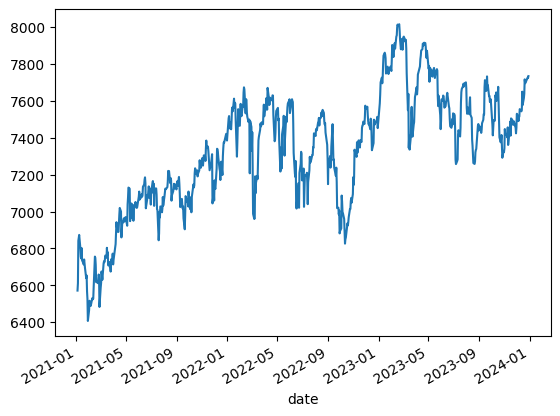

In [5]:
# Plot the Close Data
data['adj_close'].plot()

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [6]:
# Check for null values
data.isna().sum()

adj_close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64

In [7]:
# forward fill missing values
data.ffill(inplace=True)

In [8]:
# Check for null values
data.isna().sum()

adj_close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64

<Axes: xlabel='date'>

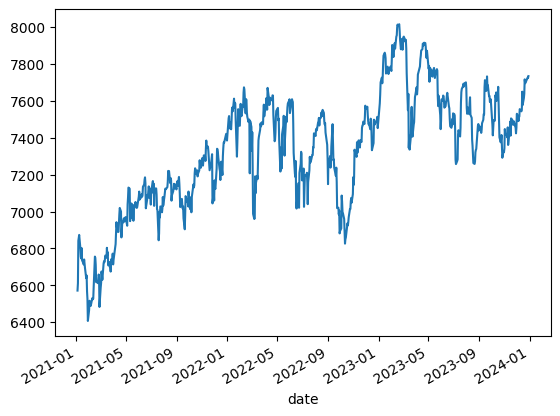

In [9]:
# Plot the cleaned Close Data
data.adj_close.plot()

In [10]:
# Plot behavior of trade output
def plot_behavior(data, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

def add_features(df: pd.DataFrame):
    # Calculate 20-day bollinger bands
    df['ma_20'] = df.adj_close.rolling(20).mean()
    vol_20 = df.adj_close.rolling(20).std()
    df['upper_bb'] = df.ma_20 + vol_20 * 2
    df['lower_bb'] = df.ma_20 - vol_20 * 2
    df.dropna(inplace=True)
    return df

def train_test_split(df: pd.DataFrame, split=0.7):
    # split dataset df into train (50%) and test (50%) datasets
    split_idx = int(len(df) * split) + 1 
    train_df =  df.iloc[:split_idx]# define training dtaframe under this variable name
    test_df =  df.iloc[split_idx:]# define testing dtaframe under this variable name
    return train_df, test_df

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [11]:
# Add features
data = add_features(data)

# Split the data into train and test sets
train_df, test_df = train_test_split(data, 0.66)

In [12]:
train_df.tail()

,adj_close,close,high,low,open,volume,ma_20,upper_bb,lower_bb
date,,,,,,,,,
2022-12-28,7497.200195,7497.200195,7547.000000,7473.000000,7473.000000,416900400,7479.925024,7613.464838,7346.385211
2022-12-29,7512.700195,7512.700195,7516.399902,7434.600098,7497.200195,351759900,7479.960034,7613.535617,7346.384452
2022-12-30,7451.700195,7451.700195,7512.899902,7451.700195,7512.700195,254135300,7473.890039,7600.496119,7347.283959
2023-01-03,7554.100098,7554.100098,7626.399902,7448.700195,7451.700195,914070400,7473.670044,7599.670932,7347.669156
2023-01-04,7585.200195,7585.200195,7609.299805,7545.200195,7554.100098,753877000,7475.120044,7605.703964,7344.536124


In [13]:

test_df.head()

,adj_close,close,high,low,open,volume,ma_20,upper_bb,lower_bb
date,,,,,,,,,
2023-01-05,7633.500000,7633.500000,7658.799805,7564.700195,7585.200195,883850800,7478.420044,7621.565252,7335.274836
2023-01-06,7699.500000,7699.500000,7700.799805,7633.500000,7633.500000,813538800,7487.325049,7660.696091,7313.954006
2023-01-09,7724.899902,7724.899902,7725.700195,7688.700195,7699.500000,847858600,7499.110034,7702.468048,7295.752020
2023-01-10,7694.500000,7694.500000,7724.899902,7684.399902,7724.899902,933139900,7510.225024,7730.949205,7289.500844
2023-01-11,7725.000000,7725.000000,7772.399902,7694.399902,7694.500000,1041280000,7522.645020,7762.525936,7282.764103


(486, 9)
              adj_close        close         high          low         open  \
date                                                                          
2022-12-28  7497.200195  7497.200195  7547.000000  7473.000000  7473.000000   
2022-12-29  7512.700195  7512.700195  7516.399902  7434.600098  7497.200195   
2022-12-30  7451.700195  7451.700195  7512.899902  7451.700195  7512.700195   
2023-01-03  7554.100098  7554.100098  7626.399902  7448.700195  7451.700195   
2023-01-04  7585.200195  7585.200195  7609.299805  7545.200195  7554.100098   

               volume        ma_20     upper_bb     lower_bb  
date                                                          
2022-12-28  416900400  7479.925024  7613.464838  7346.385211  
2022-12-29  351759900  7479.960034  7613.535617  7346.384452  
2022-12-30  254135300  7473.890039  7600.496119  7347.283959  
2023-01-03  914070400  7473.670044  7599.670932  7347.669156  
2023-01-04  753877000  7475.120044  7605.703964  7344.53612

<function matplotlib.pyplot.show(close=None, block=None)>

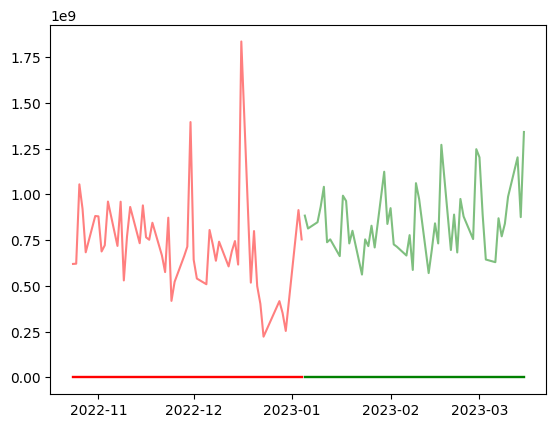

In [14]:
# display train and test dfs (ensure no overlap)
print(train_df.shape)
print(train_df.tail())
print(test_df.shape)
print(test_df.head())

plt.figure()
plt.plot(train_df.tail(50), 'r', alpha=0.5)
plt.plot(test_df.head(50), 'g', alpha=0.5)

plt.show

In [15]:
class StandardScaler:

    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data:pd.DataFrame):
        self.mean = data.mean()
        self.std = data.std()

    def transform(self, data:pd.DataFrame):
        return (data - self.mean) / self.std
    
    def fit_transform(self, data:pd.DataFrame):
        self.fit(data)
        return self.transform(data)

<Axes: xlabel='date'>

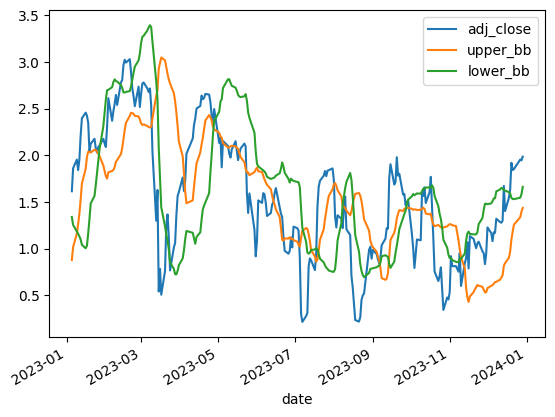

In [16]:
feature_names = ['adj_close', 'upper_bb', 'lower_bb']

# Fit the StandardScaler to the training data
scaler = StandardScaler()
scaler.fit(train_df[feature_names])

scaler.transform(test_df[feature_names]).plot()

In [17]:
class Trading_Environment:

    def __init__(self, data:pd.DataFrame, window_size:int, feature_names:list, scaler:StandardScaler):
        self.data = data
        self.window_size = window_size
        self.time_step = 0
        self.num_time_steps = len(self.data) - window_size - 1
        
        self.feature_names = feature_names
        self.scaler = scaler
        self.time_step=0
        self.terminated = False
        self.states_sell = []
        self.states_buy = []
        self.inventory = []
        self.total_profit = 0
        self.total_winners = 0
        self.total_losers = 0

        self.num_features = len(self.feature_names)
        self.observation_size = window_size - 1
        self.num_action = 3

    def reset(self):
        self.time_step = 0
        self.last_time_step = len(self.data) - 1
        self.terminated = False
        self.truncated = False
        self.states_sell_test = []
        self.states_buy_test = []
        self.states_sell = []
        self.states_buy = []
        self.inventory = []
        self.total_profit = 0
        self.total_winners = 0
        self.total_losers = 0
        self.current_data = self._get_current_data()
        state = self._get_state(self.data, self.time_step, self.window_size, self.feature_names, self.scaler)
        info = self._get_info()
        return state, info

    def step(self, action):
        self.time_step += 1
        # print(self.time_step)
        if self.time_step >= self.last_time_step:
            self.terminated = True

        self.current_data = self._get_current_data()
        
        reward = 0
        if action == 1: # buy
            # inverse transform to get true buy price in dollars
            buy_price = self.current_data['adj_close']
            # append buy prive to inventory
            self.inventory.append(buy_price)
            # append time step to states_buy_test
            self.states_buy_test.append(self.time_step)
            # print(f'Buy: {format_price(buy_price)}')
            self.states_buy.append(self.time_step)

        elif action == 2 and len(self.inventory) > 0: # sell
            # get bought price from beginning of inventory
            bought_price = self.inventory.pop(0)
            # inverse transform to get true sell price in dollars
            sell_price = self.current_data['adj_close']
            # reward is max of profit (close price at time of sell - close price at time of buy)
            profit = sell_price - bought_price
            reward = np.max(profit, 0)
            # update total_test_profit
            self.total_profit += profit
            if profit >=0:
                self.total_winners += profit
            else:
                self.total_losers += profit
            # append time step to states_sell_test
            self.states_sell_test.append(self.time_step)
            self.states_sell.append(self.time_step)
            # print(f'Sell: {format_price(sell_price)} | Profit: {format_price(sell_price - bought_price)}')

        observation = self._get_state(self.data, 
                                      self.time_step, 
                                      self.window_size, 
                                      self.feature_names, 
                                      self.scaler)
        info = self._get_info()

        return observation, reward, self.terminated, self.truncated, info

    def sample(self):
        return random.randint(0, 2)
    
    def _get_current_data(self):
        current_data = self.data.iloc[self.time_step]
        return current_data

    def render(self):
        pass

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # returns an an n-day state representation ending at time t
    def _get_state(self, data, t, n, feature_names, scaler): 
        # data is the dataset of interest which holds the state values (i.e. Close , BB Upper, BB Lower)
        # t is the current time step 
        # n is the size of the training window
        d = t - n
        # the first step is to get the window of the dataset at the current time step (eg. if window size is 1, we grab the previous and the current time step)
        # remember to define the special case for the first iteration, where there is no previous time step. See lesson X for a reminder of how to do this.
        if d >= 0:
            scaled_df = scaler.transform(data.iloc[d:t])
            window = scaled_df[feature_names].values
        else:
            scaled_df = scaler.transform(data.iloc[0])
            window = np.array([scaled_df[feature_names]] * n)
        res = []
        # print(window)
        for i in range(n - 1):
            res.append(self._sigmoid(window[i+1] - window[i]))
        
        # once we have our state data, we need to apply the sigmoid to each feature.
        # return an array holding the n-day sigmoid state representation
        return np.array(res).flatten()
    
    def _get_info(self):
        current_data = self._get_current_data()
        return {
            "date": current_data.name,
            "price": current_data['adj_close']
        }

In [18]:
window_size = 2
feature_names = ['adj_close', 'upper_bb', 'lower_bb']

baseline_env = Trading_Environment(train_df, 2, feature_names, scaler)

baseline_env.reset()

(array([0.5, 0.5, 0.5]),
 {'date': Timestamp('2021-01-29 00:00:00'), 'price': 6407.5})

In [19]:
obs, info = baseline_env.reset()
reward, terminated, truncated = 0, False, False
print(f"{obs}\n{reward}\n{terminated}\n{truncated}\n{info}\n(\n")
while True:
    obs, reward, terminated, truncated, info = baseline_env.step(0)
    if terminated or truncated:
        print(f"{obs}\n{reward}\n{terminated}\n{truncated}\n{info}\n(\n")
        break

[0.5 0.5 0.5]
0
False
False
{'date': Timestamp('2021-01-29 00:00:00'), 'price': 6407.5}
(

[0.59397619 0.49927577 0.5003799 ]
0
True
False
{'date': Timestamp('2023-01-04 00:00:00'), 'price': 7585.2001953125}
(



In [20]:
start_price = train_df.iloc[0].adj_close
end_price = train_df.iloc[-1].adj_close
profit_pct = (end_price - start_price) / start_price
print(profit_pct*100)

18.38002645825205


In [21]:
class DQN:

    def __init__(self, input_shape, n_outputs, n_hidden=64, buf_size=2000, batch_size=64, test_mode=False, model_name=''):
        self.model_name = model_name
        self.test_mode = test_mode
        if self.test_mode:
            self.model = tf.keras.models.load_model(self.model_name) if test_mode else self._model()
        else:
            self.model = tf.keras.Sequential([
                    tf.keras.layers.Dense(n_hidden, activation='elu', input_shape=input_shape),
                    tf.keras.layers.Dense(n_hidden, activation='elu'),
                    tf.keras.layers.Dense(n_outputs)
                ])
            
        self.target = tf.keras.models.clone_model(self.model)
        self.target.set_weights(self.model.get_weights())

        self.replay_buffer = deque(maxlen=buf_size)
        self.batch_size = batch_size

        self.discount_factor = 0.95
        # self.optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
        self.optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-2)
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.n_outputs = n_outputs
        self.input_shape = input_shape
        self.states_sell = []
        self.states_buy = []

    def epsilon_greedy_policy(self, state, epsilon=0):
        if not self.test_mode and np.random.rand() < epsilon:
            return np.random.randint(self.n_outputs)
        else:
            Q_values = self.model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()
    
    def sample_experiences(self, batch_size):
        indices = np.random.randint(len(self.replay_buffer), size=batch_size)
        batch = [self.replay_buffer[index] for index in indices]
        return [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(6)
        ] # [states, actions, rewards, next_states, dones, truncateds]
    
    def play_one_step(self, env, state, epsilon):
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        self.replay_buffer.append((state, action, reward, next_state, done, truncated))
        return next_state, reward, done, truncated, info
    
    def training_step(self):
        experiences = self.sample_experiences(self.batch_size)
        states, actions, rewards, next_states, dones, truncateds = experiences
        next_Q_values = self.target.predict(next_states, verbose=0)
        max_next_Q_values = next_Q_values.max(axis=1)
        runs = 1.0 - (dones | truncateds)
        target_Q_values = rewards + runs * self.discount_factor * max_next_Q_values
        target_Q_values = target_Q_values.reshape(-1, 1)
        mask = tf.one_hot(actions, self.n_outputs)
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def update_target_weights(self):
        self.target.set_weights(self.model.get_weights())


In [22]:
train_env  = Trading_Environment(train_df, 2, feature_names, scaler)

# input_shape = train_env.observation_space.shape
input_shape = [3]

# n_outputs = train_env.action_space.n
n_outputs = train_env.num_action
dqn = DQN(input_shape, n_outputs, n_hidden=128, buf_size=20000, batch_size=128)
ep_rewards = []
rewards = []
batch_losses = []

num_episodes = 1001
num_steps = 10000
for episode in range(0, num_episodes + 1):
    obs, info = train_env.reset()
    for step in range(num_steps):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = dqn.play_one_step(train_env, obs, epsilon)
        if done or truncated:
            break
        ep_rewards.append(reward)
        # avg_rewards.append(np.sum(ep_rewards))
        # ep_rewards = []
    rewards.append(np.sum(ep_rewards))
    ep_rewards = []

    if episode > 50:
        loss = dqn.training_step()
        batch_losses.append(loss)

    if episode % 50 == 0 and episode > 0:
        mean_rewards = np.mean(rewards[-50:])
        print(f"Ep: {episode} - Mean rewards: {mean_rewards}")
        dqn.update_target_weights()
        latest_model_name = f'model_ep{episode}.keras'
        dqn.model.save(latest_model_name)

2024-12-21 22:44:02.005740: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-12-21 22:44:02.005769: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-12-21 22:44:02.005777: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-12-21 22:44:02.005824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-21 22:44:02.005843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-21 22:44:02.771708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Ep: 50 - Mean rewards: 3501.140107421875


2024-12-21 22:44:57.542015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Ep: 100 - Mean rewards: 1622.68783203125
Ep: 150 - Mean rewards: 917.050185546875
Ep: 200 - Mean rewards: 2393.366337890625
Ep: 250 - Mean rewards: 849.889541015625
Ep: 300 - Mean rewards: 2949.98353515625
Ep: 350 - Mean rewards: 2619.983798828125
Ep: 400 - Mean rewards: 1488.881845703125
Ep: 450 - Mean rewards: 1250.388037109375
Ep: 500 - Mean rewards: 656.75197265625
Ep: 550 - Mean rewards: 457.31205078125
Ep: 600 - Mean rewards: 777.209921875
Ep: 650 - Mean rewards: 36.99201171875
Ep: 700 - Mean rewards: 503.88802734375
Ep: 750 - Mean rewards: 755.0059765625
Ep: 800 - Mean rewards: 37.12796875
Ep: 850 - Mean rewards: 1121.1199609375
Ep: 900 - Mean rewards: 60.36193359375
Ep: 950 - Mean rewards: 822.801923828125
Ep: 1000 - Mean rewards: 170.510009765625


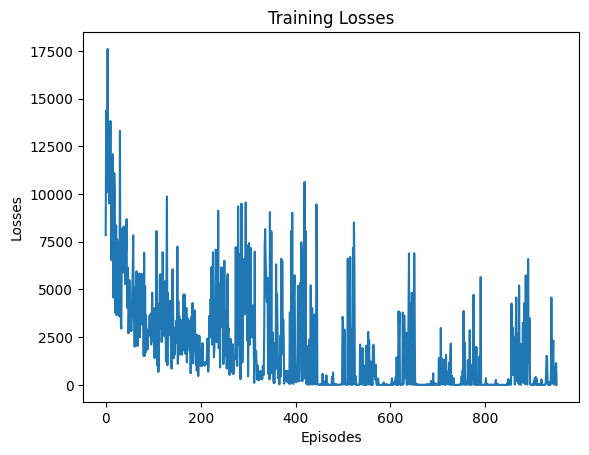

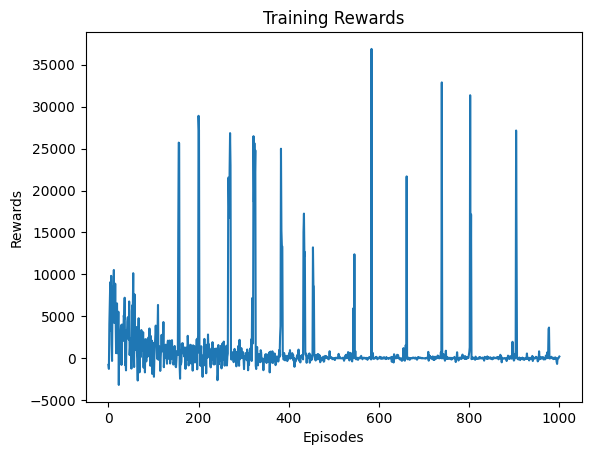

In [23]:
plt.plot(batch_losses)
plt.xlabel("Episodes")
plt.ylabel("Losses")
plt.title("Training Losses")
plt.show()
plt.clf()
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Training Rewards")
plt.plot(rewards)

plt.show()

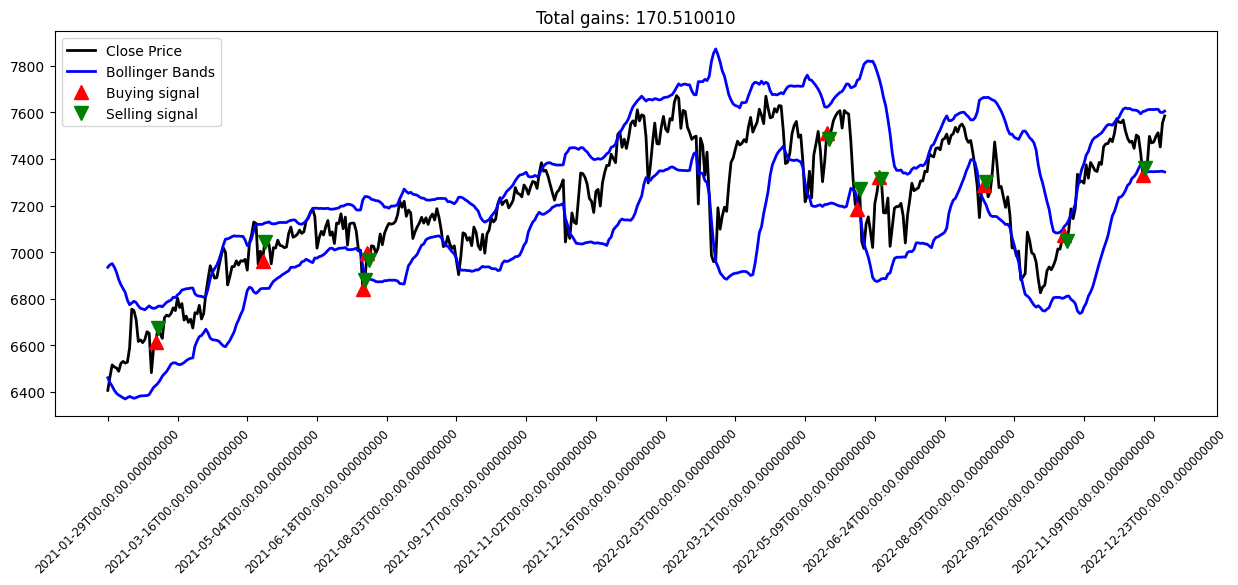

In [31]:

closes = train_df.adj_close.values
bb_upper = train_df.upper_bb.values
bb_lower = train_df.lower_bb.values
total_profit = mean_rewards
plot_behavior(closes, bb_upper, bb_lower, train_env.states_buy, train_env.states_sell, total_profit)
# (data, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True)

In [29]:
test_env = Trading_Environment(test_df, 2, feature_names, scaler)

# input_shape = train_env.observation_space.shape
input_shape = [3]

# n_outputs = train_env.action_space.n
n_outputs = test_env.num_action
dqn = DQN(input_shape, n_outputs, n_hidden=128, buf_size=20000, batch_size=128, test_mode = True, model_name="model_ep350.keras")

# num_episodes = 250
num_steps = 10000
# for episode in range(num_episodes + 1):
obs, info = test_env.reset()
for step in range(num_steps):
    # epsilon = max(1 - episode / 500, 0.01)
    obs, reward, done, truncated, info = dqn.play_one_step(test_env, obs, epsilon)
    if done or truncated:
        break
    ep_rewards.append(reward)
    # avg_rewards.append(np.sum(ep_rewards))
    # ep_rewards = []
print(np.sum(ep_rewards))



2024-12-22 07:36:55.455481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8.7001953125


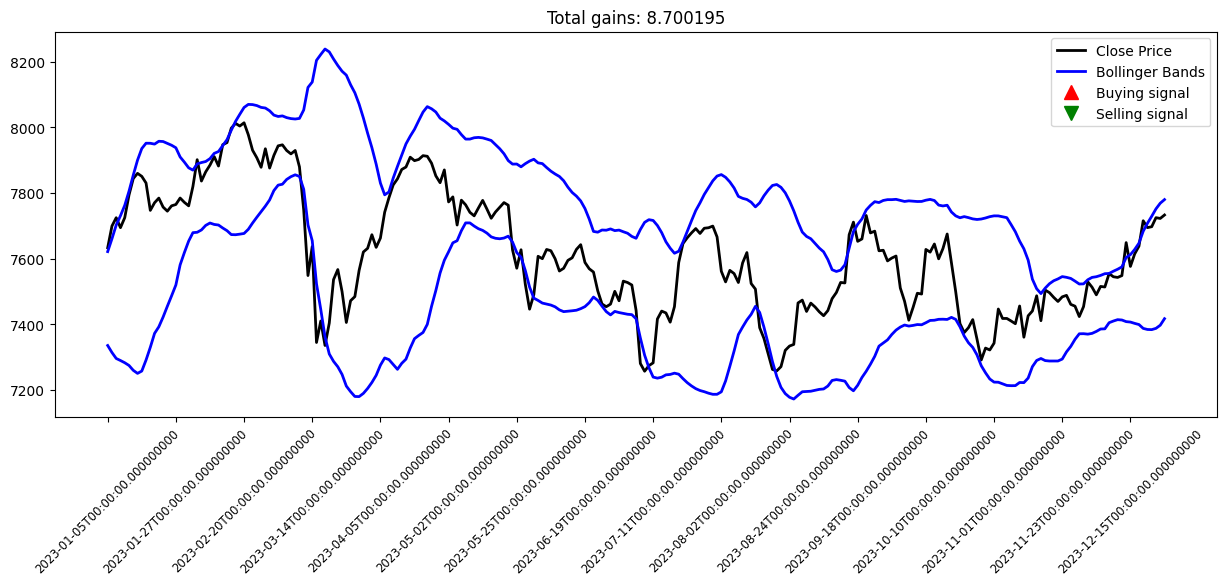

In [30]:
closes = test_df.adj_close.values
bb_upper = test_df.upper_bb.values
bb_lower = test_df.lower_bb.values
total_profit = np.sum(ep_rewards)
plot_behavior(closes, bb_upper, bb_lower, test_env.states_buy, test_env.states_sell, total_profit, train=False)